In [28]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import nltk
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
#fork

## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [29]:
#MULTI LABEL

In [30]:
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [31]:
len(train_df)

toxic = train_df[["id","comment_text","toxic"]]
toxic

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0


#### Function Creation and Setup

In [32]:

# nltk.download('all')
# for package in ['stopwords','punkt','wordnet']:
#     nltk.download(package) 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english')) 

In [33]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                tok = re.sub('\W+','', tok) #Punctuation strip
                tmp = self.lemmatizer.lemmatize(tok)
                if len(tmp) >= 2:
                    filtered_tok.append(tmp)
        return filtered_tok

In [35]:
tok = lemmaTokenizer(stop_words)
toxic["clean_text"] = toxic["comment_text"].apply(lambda x: tok(x))

C:\Users\Shaun\AppData\Local\Temp\ipykernel_346108\2617075832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxic["clean_text"] = toxic["comment_text"].apply(lambda x: tok(x))


In [36]:
sToxic = train_df[["id","comment_text","severe_toxic"]]
sToxic["clean_text"] = sToxic["comment_text"].apply(lambda x: tok(x))

C:\Users\Shaun\AppData\Local\Temp\ipykernel_346108\2653484228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sToxic["clean_text"] = sToxic["comment_text"].apply(lambda x: tok(x))


In [37]:
obscene = train_df[["id","comment_text","obscene"]]
obscene["clean_text"] = obscene["comment_text"].apply(lambda x: tok(x))

C:\Users\Shaun\AppData\Local\Temp\ipykernel_346108\1206414034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obscene["clean_text"] = obscene["comment_text"].apply(lambda x: tok(x))


In [38]:
threat = train_df[["id","comment_text","threat"]]
threat["clean_text"] = threat["comment_text"].apply(lambda x: tok(x))

C:\Users\Shaun\AppData\Local\Temp\ipykernel_346108\1808506550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  threat["clean_text"] = threat["comment_text"].apply(lambda x: tok(x))


In [39]:
idHate = train_df[["id","comment_text","identity_hate"]]
idHate["clean_text"] = idHate["comment_text"].apply(lambda x: tok(x))

C:\Users\Shaun\AppData\Local\Temp\ipykernel_346108\1931678255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idHate["clean_text"] = idHate["comment_text"].apply(lambda x: tok(x))


In [40]:
insult = train_df[["id","comment_text","insult"]]
insult["clean_text"] = insult["comment_text"].apply(lambda x: tok(x))

C:\Users\Shaun\AppData\Local\Temp\ipykernel_346108\4030220598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insult["clean_text"] = insult["comment_text"].apply(lambda x: tok(x))


In [41]:
toxic

,id,comment_text,toxic,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,"[Explanation, Why, edits, made, username, Hard..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,"[Daww, He, match, background, colour, seemingl..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,"[Hey, man, really, trying, edit, war, It, guy,..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,"[More, ca, nt, make, real, suggestion, improve..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"[You, sir, hero, Any, chance, remember, page]"
...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,"[And, second, time, asking, view, completely, ..."
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,"[You, ashamed, That, horrible, thing, put, tal..."
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,"[Spitzer, Umm, there, actual, article, prostit..."
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,"[And, look, like, actually, put, speedy, first..."


#### Model Creation

In [42]:
# create Word2vec model
modelToxic = Word2Vec(toxic['clean_text'],min_count=3, vector_size=200, sg=0)
modelSToxic = Word2Vec(sToxic['clean_text'],min_count=3, vector_size=200, sg=0)
modelObscene = Word2Vec(obscene['clean_text'],min_count=3, vector_size=200, sg=0)
modelInsult = Word2Vec(insult['clean_text'],min_count=3, vector_size=200, sg=0)
modelIDHate = Word2Vec(idHate['clean_text'],min_count=3, vector_size=200, sg=0)
modelThreat = Word2Vec(threat['clean_text'],min_count=3, vector_size=200, sg=0)
#min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

#combination of word and its vector
w2vToxic = dict(zip(modelToxic.wv.index_to_key, modelToxic.wv.vectors))
w2vSToxic = dict(zip(modelSToxic.wv.index_to_key, modelSToxic.wv.vectors))
w2vObscene = dict(zip(modelObscene.wv.index_to_key, modelObscene.wv.vectors))
w2vInsult = dict(zip(modelInsult.wv.index_to_key, modelInsult.wv.vectors))
w2vIDHate = dict(zip(modelIDHate.wv.index_to_key, modelIDHate.wv.vectors))
w2vThreat = dict(zip(modelThreat.wv.index_to_key, modelThreat.wv.vectors))

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# Toxic

AUC: 0.9302250777296459
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     35999
           1       0.86      0.47      0.61      3894

    accuracy                           0.94     39893
   macro avg       0.90      0.73      0.79     39893
weighted avg       0.94      0.94      0.93     39893



<AxesSubplot:>

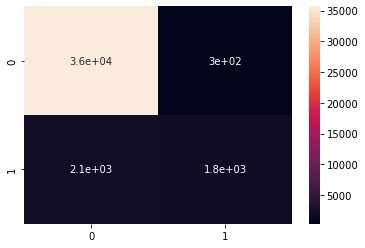

In [43]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(toxic["clean_text"],toxic["toxic"])

#Word2vec
# Fit and transform
toxicMeanEmbedVectorizer = MeanEmbeddingVectorizer(w2vToxic)

X_train_vectors_w2v = toxicMeanEmbedVectorizer.transform(X_train)
X_test_vectors_w2v = toxicMeanEmbedVectorizer.transform(X_test)

toxicModel = RandomForestClassifier()
toxicModel.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = toxicModel.predict(X_test_vectors_w2v)
y_prob = toxicModel.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

# Severely Toxic

AUC: 0.9467104340793021
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39507
           1       0.62      0.15      0.25       386

    accuracy                           0.99     39893
   macro avg       0.81      0.58      0.62     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

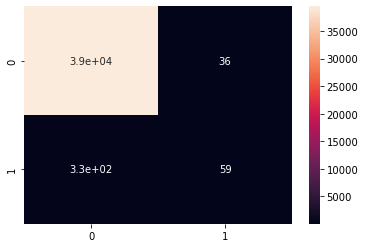

In [44]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(sToxic["clean_text"],sToxic["severe_toxic"])

#Word2vec
# Fit and transform
severeMeanEmbeddingVectorizer = MeanEmbeddingVectorizer(w2vToxic)

X_train_vectors_w2v = severeMeanEmbeddingVectorizer.transform(X_train)
X_test_vectors_w2v = severeMeanEmbeddingVectorizer.transform(X_test)

severeModel = RandomForestClassifier()
severeModel.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = severeModel.predict(X_test_vectors_w2v)
y_prob = severeModel.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

# Obscene

AUC: 0.9350911777355195
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     37773
           1       0.87      0.43      0.57      2120

    accuracy                           0.97     39893
   macro avg       0.92      0.71      0.78     39893
weighted avg       0.96      0.97      0.96     39893



<AxesSubplot:>

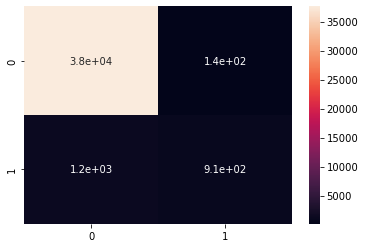

In [45]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(obscene["clean_text"],obscene["obscene"])

#Word2vec
# Fit and transform
obsceneMeanEmbeddingVectorizer = MeanEmbeddingVectorizer(w2vToxic)

X_train_vectors_w2v = obsceneMeanEmbeddingVectorizer.transform(X_train)
X_test_vectors_w2v = obsceneMeanEmbeddingVectorizer.transform(X_test)

obsceneModel = RandomForestClassifier()
obsceneModel.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = obsceneModel.predict(X_test_vectors_w2v)
y_prob = obsceneModel.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

# Insult

AUC: 0.9409632025449094
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     37857
           1       0.82      0.38      0.52      2036

    accuracy                           0.96     39893
   macro avg       0.89      0.69      0.75     39893
weighted avg       0.96      0.96      0.96     39893



<AxesSubplot:>

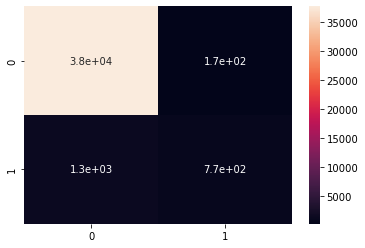

In [46]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(insult["clean_text"],insult["insult"])

#Word2vec
# Fit and transform
insultMeanEmbeddingVectorizer = MeanEmbeddingVectorizer(w2vToxic)

X_train_vectors_w2v = insultMeanEmbeddingVectorizer.transform(X_train)
X_test_vectors_w2v = insultMeanEmbeddingVectorizer.transform(X_test)

insultModel = RandomForestClassifier()
insultModel.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = insultModel.predict(X_test_vectors_w2v)
y_prob = insultModel.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

# Identity Hate

AUC: 0.9144311869207711
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39525
           1       0.79      0.04      0.08       368

    accuracy                           0.99     39893
   macro avg       0.89      0.52      0.54     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

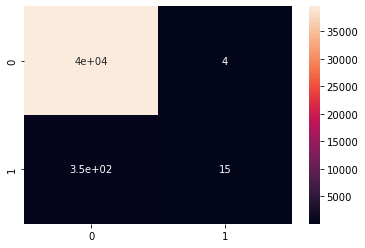

In [47]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(idHate["clean_text"],idHate["identity_hate"])

#Word2vec
# Fit and transform
idHateMeanEmbeddingVectorizer = MeanEmbeddingVectorizer(w2vToxic)

X_train_vectors_w2v = idHateMeanEmbeddingVectorizer.transform(X_train)
X_test_vectors_w2v = idHateMeanEmbeddingVectorizer.transform(X_test)

idHatePredictionModel = RandomForestClassifier()
idHatePredictionModel.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = idHatePredictionModel.predict(X_test_vectors_w2v)
y_prob = idHatePredictionModel.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

# Threat

AUC: 0.9172112978128931
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39777
           1       0.75      0.03      0.05       116

    accuracy                           1.00     39893
   macro avg       0.87      0.51      0.52     39893
weighted avg       1.00      1.00      1.00     39893



<AxesSubplot:>

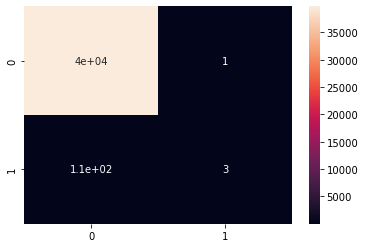

In [48]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(threat["clean_text"],threat["threat"])

#Word2vec
# Fit and transform
threatVectorizeModel = MeanEmbeddingVectorizer(w2vToxic)

X_train_vectors_w2v = threatVectorizeModel.transform(X_train)
X_test_vectors_w2v = threatVectorizeModel.transform(X_test)

threatPredictionModel = RandomForestClassifier()
threatPredictionModel.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = threatPredictionModel.predict(X_test_vectors_w2v)
y_prob = threatPredictionModel.predict_proba(X_test_vectors_w2v)[:,1]
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

print(classification_report(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)

## Test Data

In [49]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


In [50]:
test_df["clean_text"] = test_df["comment_text"].apply(lambda x: tok(x))

In [51]:
#Toxic final prediction
test_vectors_toxic = toxicMeanEmbedVectorizer.transform(test_df["clean_text"])
yToxic = toxicModel.predict(test_vectors_toxic)

#Severely toxic final prediction
test_vectors_severe = severeMeanEmbeddingVectorizer.transform(test_df["clean_text"])
ySevere = severeModel.predict(test_vectors_toxic)

#Obscene final prediction
test_vectors_obscene = obsceneMeanEmbeddingVectorizer.transform(test_df["clean_text"])
yObscene = obsceneModel.predict(test_vectors_toxic)

#Insult final prediction
test_vectors_insult = insultMeanEmbeddingVectorizer.transform(test_df["clean_text"])
yInsult = insultModel.predict(test_vectors_toxic)

#Identity Hate final prediction
test_vectors_idhate = idHateMeanEmbeddingVectorizer.transform(test_df["clean_text"])
yIDHate = idHatePredictionModel.predict(test_vectors_toxic)

#Threat final prediction
test_vectors_threat = threatVectorizeModel.transform(test_df["clean_text"])
yThreat = threatPredictionModel.predict(test_vectors_toxic)

In [55]:
#now kith
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
thisIsGoingOut = pd.DataFrame(list(zip(test_df["id"], yToxic, ySevere,yObscene, yThreat, yInsult, yIDHate)),
                              columns=columns)
thisIsGoingOut.to_csv('out.csv', index=False)  

## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [53]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
# dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
# dummy_toxic = [0,0,0,0]
# dummy_severe = [0,0,0,0]
# dummy_obscene = [0,1,1,0]
# dummy_threat = [0,1,0,1]
# dummy_insult = [0,0,1,0]
# dummy_ident = [0,1,1,0]
# columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
#                     columns=columns)
# sample_out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,dfasdf234,0,0,0,0,0,0
1,asdfgw43r52,0,0,1,1,0,1
2,asdgtawe4,0,0,1,0,1,1
3,wqtr215432,0,0,0,1,0,0


In [54]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
# sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>